## 5.3　評価基準とスコア

### 5.3.2　2 クラス分類における基準

In [1]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from mglearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS

In [2]:
np.set_printoptions(precision=3, floatmode='maxprec')

#### 5.3.2.2　偏ったデータセット

In [3]:
digits = load_digits()
y = digits.target == 9
print(y[:10])
print(digits.data.shape)
print(digits.target.shape)

[False False False False False False False False False  True]
(1797, 64)
(1797,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

In [5]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)

print('Unique predicted labels: {}'.format(np.unique(pred_most_frequent)))
print('Test score: {:.2f}'.format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


In [6]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)

print('Test score: {:.2f}'.format(tree.score(X_test, y_test)))

Test score: 0.92


In [7]:
dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)

print('dummy score: {:.2f}'.format(dummy.score(X_test, y_test)))

dummy score: 0.90


In [8]:
logreg = LogisticRegression(C=0.1, max_iter=1000).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)

print('logreg score: {:.2f}'.format(logreg.score(X_test, y_test)))

logreg score: 0.98


#### 5.3.2.3　混同行列

In [9]:
confusion = confusion_matrix(y_test, pred_logreg)

print('Confusion matrix:\n{}'.format(confusion))

Confusion matrix:
[[402   1]
 [  6  41]]


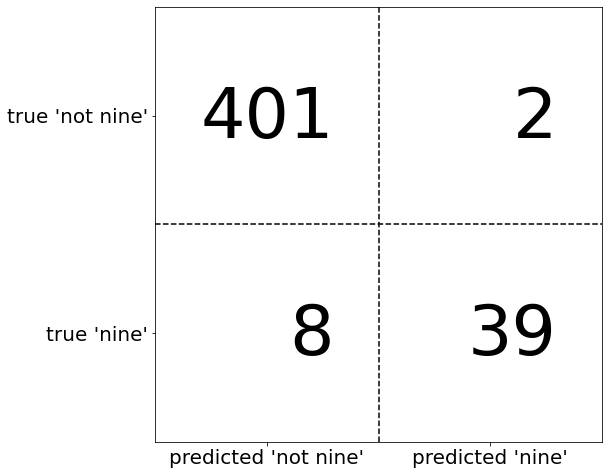

In [10]:
mglearn.plots.plot_confusion_matrix_illustration()

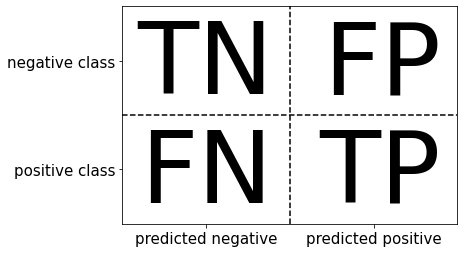

In [11]:
mglearn.plots.plot_binary_confusion_matrix()

以下のように覚えておけば良い。

`TP`：真陽性、`FP`：偽陽性、`FN`：偽陰性、`TN`：真陰性

適合率は 偽陽性 `FP` を減らしたい、再現率は 偽陰性 `FN` を減らしたいのである。

In [12]:
print('Most frequent class:')
print(confusion_matrix(y_test, pred_most_frequent))
print('\nDummy model:')
print(confusion_matrix(y_test, pred_dummy))
print('\nDecision tree:')
print(confusion_matrix(y_test, pred_tree))
print('\nLogistic Regression:')
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[403   0]
 [ 47   0]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression:
[[402   1]
 [  6  41]]


適合率 `precision`：陽性と予測して、実際に陽性だった割合<br>
再現率 `recall`：陽性クラスに対して、実際に陽性と正しく予測できた割合

これらどちらか一方だけでは全体像が掴めないので、F値 `f1_score` を使用する。

In [13]:
print('f1 score most frequent: {:.2f}'.format(f1_score(y_test, pred_most_frequent)))
print('f1 score most frequent: {:.2f}'.format(f1_score(y_test, pred_dummy)))
print('f1 score most frequent: {:.2f}'.format(f1_score(y_test, pred_tree)))
print('f1 score most frequent: {:.2f}'.format(f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score most frequent: 0.00
f1 score most frequent: 0.55
f1 score most frequent: 0.92


In [14]:
print(classification_report(y_test, pred_tree, target_names=['not_nine', 'nine']))

              precision    recall  f1-score   support

    not_nine       0.94      0.97      0.95       403
        nine       0.64      0.49      0.55        47

    accuracy                           0.92       450
   macro avg       0.79      0.73      0.75       450
weighted avg       0.91      0.92      0.91       450



In [15]:
print(classification_report(y_test, pred_logreg, target_names=['not_nine', 'nine']))

              precision    recall  f1-score   support

    not_nine       0.99      1.00      0.99       403
        nine       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



#### 5.3.2.4　不確実性を考慮に入れる

In [16]:
X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

/Library/Python/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


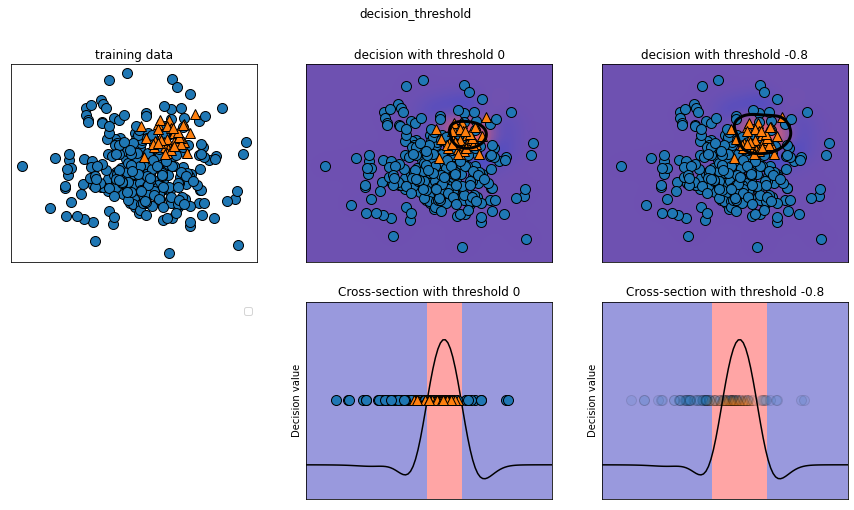

In [17]:
mglearn.plots.plot_decision_threshold()

In [18]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



In [19]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



#### 5.3.2.5　適合率 - 再現率カーブと ROC カーブ

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

In [21]:
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/Library/Python/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


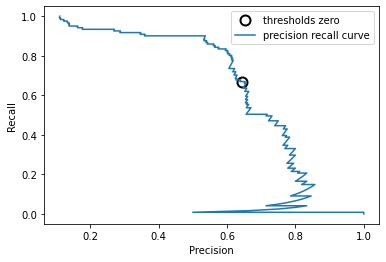

In [22]:
svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='thresholds zero', fillstyle='none', c='k', mew=2)
plt.plot(precision, recall, label='precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')

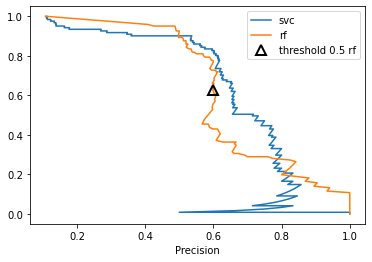

In [23]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label='svc')
plt.plot(precision_rf, recall_rf, label='rf')
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k', markersize=10, label='threshold 0.5 rf', fillstyle='none', mew=2)
plt.xlabel('Precision')
plt.legend(loc='best')

スレッショルドとは、閾値のことである。<br>
svc は `decision_function` のため 0、rf は `predict_proba` のため 0.5 がデフォルトの閾値である。

`f1_score` は、デフォルトの閾値で与えられる 1 点のみを表しているにすぎない。

In [24]:
print('f1_score of random forest: {:.3f}'.format(f1_score(y_test, rf.predict(X_test))))
print('f1_score of svc: {:.3f}'.format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


デフォルト値ではなく、様々な閾値や作動ポイントでの性能を表すには、カーブ下の領域を積分すれば良い。<br>
複数の閾値を考慮する必要があるため、`decision_function` もしくは `predict_proba` の結果を渡す必要がある。

In [25]:
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print('Average precision of random forest: {:.3f}'.format(ap_rf))
print('Average precision of svc: {:.3f}'.format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


#### 5.3.2.6　受信者動作特性（ROC）と AUC

`ROC` とは、受信者動作特性カーブ（`R`eceiver `O`perating `C`urve）の略である。<br>
適合率と再現率の代わりに、偽陽性率と真陽性率を使用する。ただし、真陽性率は再現率と同じものである。

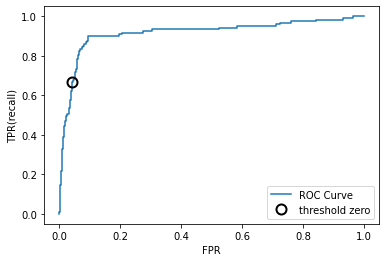

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)
plt.legend(loc=4)

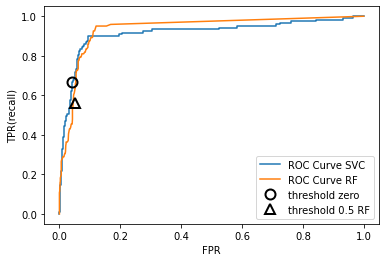

In [27]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label='ROC Curve SVC')
plt.plot(fpr_rf, tpr_rf, label='ROC Curve RF')

plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10, label='threshold 0.5 RF', fillstyle='none', c='k', mew=2)
plt.legend(loc=4)

In [28]:
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print('AUC for Random Forest: {:.3f}'.format(rf_auc))
print('AUC for SVC: {:.3f}'.format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


In [29]:
y = digits.target == 9
print(y[:10])

[False False False False False False False False False  True]


gamma = 1.00  accuracy = 0.90  AUC = 0.50
gamma = 0.05  accuracy = 0.90  AUC = 1.00
gamma = 0.01  accuracy = 0.90  AUC = 1.00


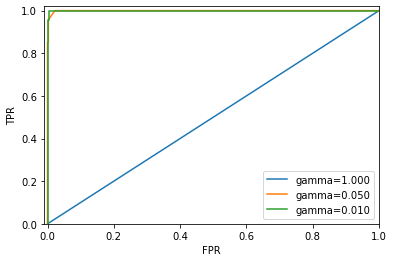

In [30]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)
plt.figure()

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test))
    
    print('gamma = {:.2f}  accuracy = {:.2f}  AUC = {:.2f}'.format(gamma, accuracy, auc))
    plt.plot(fpr, tpr, label='gamma={:.3f}'.format(gamma))
    
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc='best')

`AUC` が高かったとしても、デフォルトのスレッショルドに対応する点が、グラフの下の方にあることもあるので<br>
スレッショルド（閾値）の調整が必要になるケースが存在することも、頭に入れておく必要がある。

### 5.3.3　多クラス分類の基準

In [31]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)
lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
pred = lr.predict(X_test)

print('Accuracy: {:.3f}'.format(accuracy_score(y_test, pred)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  2  1]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  0 44  0  0  0  0  1  0]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  1  0  0  0  1  0 43  0]
 [ 0  0  0  0  0  1  0  0  2 44]]


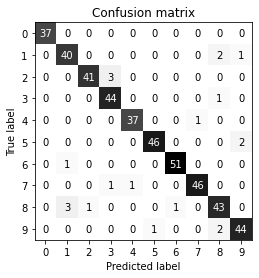

In [32]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred),
    xlabel='Predicted label',
    ylabel='True label',
    xticklabels=digits.target_names,
    yticklabels=digits.target_names,
    cmap=plt.cm.gray_r,fmt='%d')

plt.title('Confusion matrix')
plt.gca().invert_yaxis()

In [33]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.91      0.93      0.92        43
           2       0.98      0.93      0.95        44
           3       0.92      0.98      0.95        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       0.98      0.98      0.98        52
           7       0.98      0.96      0.97        48
           8       0.90      0.90      0.90        48
           9       0.94      0.94      0.94        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



In [34]:
print('Micro average f1 score: {:.3f}'.format(f1_score(y_test, pred, average='micro')))
print('Macro average f1 score: {:.3f}'.format(f1_score(y_test, pred, average='macro')))

Micro average f1 score: 0.953
Macro average f1 score: 0.954


### 5.3.5　評価基準を用いたモデル選択

In [35]:
explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target==9, scoring='accuracy')
roc_auc = cross_val_score(SVC(), digits.data, digits.target==9, scoring='roc_auc')

print('Default scoring: {}'.format(cross_val_score(SVC(), digits.data, digits.target==9)))
print('Explicit accuracy scoring: {}'.format(explicit_accuracy))
print('AUC scoring: {}'.format(roc_auc))

Default scoring: [0.975 0.992 1.    0.994 0.981]
Explicit accuracy scoring: [0.975 0.992 1.    0.994 0.981]
AUC scoring: [0.997 0.999 1.    1.    0.984]


In [36]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target==9, random_state=0)

In [37]:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)

print('Grid-Search with accuracy')
print('Best parameters:', grid.best_params_)
print('Best cross-validation score (accuracy): {:.3f}'.format(grid.best_score_))
print('Test set AUC: {:.3f}'.format(roc_auc_score(y_test, grid.decision_function(X_test))))
print('Test set accuracy: {:.3f}'.format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy): 0.976
Test set AUC: 0.992
Test set accuracy: 0.973


In [38]:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring='roc_auc')
grid.fit(X_train, y_train)

print('Grid-Search with AUC')
print('Best parameters:', grid.best_params_)
print('Best cross-validation score (accuracy): {:.3f}'.format(grid.best_score_))
print('Test set AUC: {:.3f}'.format(roc_auc_score(y_test, grid.decision_function(X_test))))
print('Test set accuracy: {:.3f}'.format(grid.score(X_test, y_test)))

Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (accuracy): 0.998
Test set AUC: 1.000
Test set accuracy: 1.000


偏ったデータセットに対しては、精度 `accuracy` よりも カーブの下の領域`AUC` の方が精度が良い。

In [39]:
print('Available scorers:\n{}'.format(sorted(SCORERS.keys())))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v